# Hierarchical Fine Tuning

**Model: SciBERT**

**Method: H-CAT**

**Data: OC-Mini**

**Tuner: Vikram**

In [ ]:
# IMPORTS AND DIRECTORY INITIALIZATION
import numpy as np
import torch
from pathlib import Path
import pandas as pd
from transformers import AutoTokenizer, AutoModel
from tqdm.auto import tqdm
from docx import Document
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from torch.nn import TripletMarginLoss
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

BASE_DIR = Path.cwd().parent.parent
DATA_DIR = BASE_DIR / "oc_mini"

## Load Embedder and Data

In [2]:
def compute_embeddings(texts, model, tokenizer, device):
    """Compute embeddings for a list of texts."""
    if not texts:
        return np.array([])
    
    inputs = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    ).to(device)
    
    with torch.no_grad():
        outputs = model(**inputs)
        embeddings = outputs.last_hidden_state[:, 0, :]
    
    return embeddings.cpu().numpy()

In [3]:
import json

# CLUSTER LOADING

cluster_path = DATA_DIR / "clustering" / "hierarchical" / "oc_mini_paris.json"
metadata_path = DATA_DIR / "metadata" / "oc_mini_node_metadata.csv"

with open(cluster_path, 'r') as f:
    cluster_data = json.load(f)

# Sanity Check
print(f"Loaded cluster data: {len(cluster_data)}")

Loaded cluster data: 4


In [ ]:
# Load SciBERT model and tokenizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model_name = "allenai/scibert_scivocab_uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)

print(f"SciBERT model loaded: {model_name}")

# Embed a sample sentence
sample_sentence = "The relationship between quantum mechanics and general relativity remains one of the most important unsolved problems in theoretical physics."

embedding = compute_embeddings([sample_sentence], model, tokenizer, device)

print(f"\nSample sentence: {sample_sentence}")
print(f"Embedding shape: {embedding.shape}")
print(f"Embedding (first 10 dimensions): {embedding[0][:10]}")

In [ ]:
metadata_df = pd.read_csv(metadata_path)

metadata_df.head()

,id,doi,title,abstract
0,128,10.1101/2021.05.10.443415,Improved protein contact prediction using dime...,AbstractDeep residual learning has shown great...
1,163,10.1101/2021.05.07.443114,Following the Trail of One Million Genomes: Fo...,AbstractSevere acute respiratory syndrome coro...
2,200,10.1101/2021.05.11.443555,Mechanism of molnupiravir-induced SARS-CoV-2 m...,Molnupiravir is an orally available antiviral ...
3,941,10.3390/ijms20020449,Bactericidal and Cytotoxic Properties of Silve...,Silver nanoparticles (AgNPs) can be synthesize...
4,1141,10.3390/ijms20040865,Silver Nanoparticles: Synthesis and Applicatio...,"Over the past few decades, metal nanoparticles..."


## Baseline Evaluation

SciBERT is fine-tuned with masked token prediction on scientific literature. How well does it perform on down stream network-content tasks?

In [ ]:
# ============================================================================
# EVALUATE ORIGINAL SCIBERT EMBEDDINGS (BEFORE FINE-TUNING)
# ============================================================================

print("="*60)
print("EVALUATING ORIGINAL SCIBERT ON LINK PREDICTION")
print("="*60)

# Import evaluation functions
import sys
sys.path.append(str(BASE_DIR / "cat" / "experiments"))
from network_link_prediction import (
    evaluate_network_link_prediction,
    plot_link_prediction_results,
    get_node_degree,
    load_network_edges
)

EVALUATING ORIGINAL SCIBERT ON LINK PREDICTION


In [ ]:
# ============================================================================
# STEP 1: COMPUTE EMBEDDINGS FOR ALL NODES
# ============================================================================

def compute_all_node_embeddings(model, tokenizer, metadata_df, device, batch_size=32):
    """Compute embeddings for all nodes in metadata"""
    embeddings_dict = {}
    
    # Get all node IDs from metadata
    node_ids = metadata_df['id'].astype(str).values
    texts = []
    valid_ids = []
    
    print(f"Preparing texts for {len(node_ids)} nodes...")
    for node_id in tqdm(node_ids, desc="Preparing"):
        row = metadata_df[metadata_df['id'] == int(node_id)].iloc[0]
        title = str(row['title']) if pd.notna(row['title']) else ""
        abstract = str(row['abstract']) if pd.notna(row['abstract']) else ""
        text = f"{title} {abstract}".strip()
        
        if text:  # Only add if we have text
            texts.append(text)
            valid_ids.append(node_id)
    
    print(f"Computing embeddings for {len(texts)} nodes...")
    
    # Compute embeddings in batches
    model.eval()
    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size), desc="Computing embeddings"):
            batch_texts = texts[i:i+batch_size]
            batch_ids = valid_ids[i:i+batch_size]
            
            inputs = tokenizer(
                batch_texts,
                padding=True,
                truncation=True,
                max_length=512,
                return_tensors="pt"
            ).to(device)
            
            outputs = model(**inputs)
            # Use CLS token (consistent with your original approach)
            embeddings = outputs.last_hidden_state[:, 0, :]
            embeddings = embeddings.cpu().numpy()
            
            for node_id, emb in zip(batch_ids, embeddings):
                embeddings_dict[node_id] = emb
    
    return embeddings_dict

# Compute embeddings using the ORIGINAL SciBERT model
print("\nComputing embeddings with original SciBERT...")
original_embeddings = compute_all_node_embeddings(
    model,           # Your original model from cell 4
    tokenizer,       # Your tokenizer from cell 4
    metadata_df,     # Your metadata from cell 5
    device,
    batch_size=32
)

print(f"\n✓ Computed embeddings for {len(original_embeddings)} nodes")



Computing embeddings with original SciBERT...
Preparing texts for 14442 nodes...


Preparing:   0%|          | 0/14442 [00:00<?, ?it/s]

Computing embeddings for 14442 nodes...


Computing embeddings:   0%|          | 0/452 [00:00<?, ?it/s]


✓ Computed embeddings for 14442 nodes


In [ ]:
# ============================================================================
# STEP 2: CREATE TEST SET
# ============================================================================

# Get all node IDs that have embeddings
all_node_ids = list(original_embeddings.keys())

# Create a test set (10% of nodes)
np.random.seed(42)
n_test = int(0.1 * len(all_node_ids))
test_indices = np.random.choice(len(all_node_ids), n_test, replace=False)
test_nodes = [all_node_ids[i] for i in test_indices]

print(f"\nTest set: {len(test_nodes)} nodes")


Test set: 1444 nodes



NETWORK STATISTICS
Total edges: 111,873

Degree Statistics:
  Average degree: 15.6
  Median degree: 10.5
  Max degree: 1583
  Min degree: 1


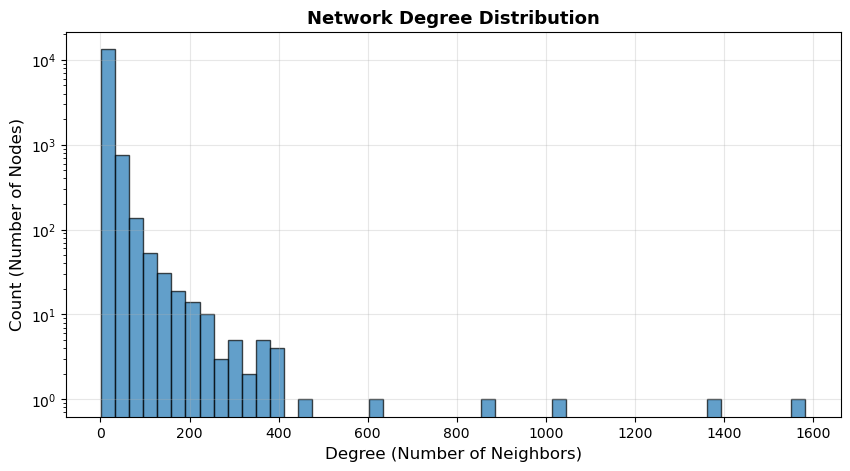

In [ ]:
# ============================================================================
# STEP 3: ANALYZE NETWORK STATISTICS
# ============================================================================

edgelist_path = DATA_DIR / "network" / "oc_mini_edgelist.csv"
edgelist_df = load_network_edges(str(edgelist_path))

print("\n" + "="*60)
print("NETWORK STATISTICS")
print("="*60)
print(f"Total edges: {len(edgelist_df):,}")

# Get degree statistics
degrees = get_node_degree(edgelist_df)
degree_values = list(degrees.values())

print(f"\nDegree Statistics:")
print(f"  Average degree: {np.mean(degree_values):.1f}")
print(f"  Median degree: {np.median(degree_values):.1f}")
print(f"  Max degree: {np.max(degree_values)}")
print(f"  Min degree: {np.min(degree_values)}")

# Plot degree distribution
plt.figure(figsize=(10, 5))
plt.hist(degree_values, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Degree (Number of Neighbors)', fontsize=12)
plt.ylabel('Count (Number of Nodes)', fontsize=12)
plt.title('Network Degree Distribution', fontsize=13, fontweight='bold')
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# ============================================================================
# STEP 4: RUN LINK PREDICTION EVALUATION
# ============================================================================

# Choose K values based on degree statistics
avg_degree = int(np.mean(degree_values))
k_values = [5, 10, 20, 50, 100]

# Add adaptive K based on average degree
if avg_degree > 100:
    k_values.append(avg_degree)
    k_values.append(200)

print(f"\nEvaluating with K values: {k_values}")

# Run evaluation
baseline_results = evaluate_network_link_prediction(
    edgelist_path=str(edgelist_path),
    embeddings_dict=original_embeddings,
    test_nodes=test_nodes,
    k_values=k_values,
    compute_auc=True,
    num_negative_samples=10
)


Evaluating with K values: [5, 10, 20, 50, 100]

NETWORK LINK PREDICTION EVALUATION

Loading edgelist from: /home/vikramr2/oc_mini/network/oc_mini_edgelist.csv
Loaded 111873 edges
Network has 14384 unique nodes
Test nodes with embeddings and edges: 1439

Evaluating link prediction with top-k retrieval...
Test nodes: 1439
K values: [5, 10, 20, 50, 100]


Evaluating nodes:   0%|          | 0/1439 [00:00<?, ?it/s]


Evaluating link prediction with AUC metrics...
Test nodes: 1439
Negative samples per positive: 10


Sampling edges:   0%|          | 0/1439 [00:00<?, ?it/s]


RESULTS SUMMARY

Top-K Metrics:
  K=5:
    Precision@5: 0.0257
    Recall@5: 0.0109
    Hit Rate@5: 0.1119
  K=10:
    Precision@10: 0.0202
    Recall@10: 0.0158
    Hit Rate@10: 0.1564
  K=20:
    Precision@20: 0.0161
    Recall@20: 0.0262
    Hit Rate@20: 0.2314
  K=50:
    Precision@50: 0.0121
    Recall@50: 0.0479
    Hit Rate@50: 0.3746
  K=100:
    Precision@100: 0.0093
    Recall@100: 0.0774
    Hit Rate@100: 0.4920

AUC Metrics:
  AUC-ROC: 0.6453
  AUC-PR: 0.1959



## H-CAT Finetuning

### Part 1: Create the Tree Utilities

First, we need a data structure to hold the tree with our Paris clustering of OC-mini 

In [ ]:
# ============================================================================
# PART 1: HIERARCHICAL TREE UTILITIES
# ============================================================================

from dataclasses import dataclass
from typing import Optional, List, Dict, Tuple
import random

@dataclass
class TreeNode:
    """Represents a node in the hierarchical tree"""
    id: int
    type: str  # 'leaf' or 'cluster'
    name: Optional[str] = None
    distance: Optional[float] = None
    count: int = 1
    children: List['TreeNode'] = None
    parent: Optional['TreeNode'] = None
    depth: int = 0

    def __post_init__(self):
        if self.children is None:
            self.children = []


class HierarchicalTree:
    """Parse and navigate hierarchical tree structure"""

    def __init__(self, tree_dict: Dict):
        """Load tree from dictionary (loaded JSON)"""
        self.root = self._parse_tree(tree_dict['hierarchy'])
        self.leaves = {}  # Map leaf name to TreeNode
        self.all_nodes = {}  # Map node id to TreeNode
        self._build_indices(self.root)
        self._compute_depths(self.root, 0)

    def _parse_tree(self, node_dict: Dict, parent=None) -> TreeNode:
        """Recursively parse tree structure"""
        node = TreeNode(
            id=node_dict['id'],
            type=node_dict['type'],
            name=node_dict.get('name'),
            distance=node_dict.get('distance'),
            count=node_dict.get('count', 1),
            parent=parent
        )

        if 'children' in node_dict:
            node.children = [
                self._parse_tree(child, parent=node)
                for child in node_dict['children']
            ]

        return node

    def _build_indices(self, node: TreeNode):
        """Build lookup indices for leaves and all nodes"""
        self.all_nodes[node.id] = node

        if node.type == 'leaf':
            self.leaves[node.name] = node

        for child in node.children:
            self._build_indices(child)

    def _compute_depths(self, node: TreeNode, depth: int):
        """Compute depth for each node"""
        node.depth = depth
        for child in node.children:
            self._compute_depths(child, depth + 1)

    def find_lca(self, node1: TreeNode, node2: TreeNode) -> TreeNode:
        """Find lowest common ancestor of two nodes"""
        # Get ancestors of node1
        ancestors1 = set()
        current = node1
        while current is not None:
            ancestors1.add(current.id)
            current = current.parent

        # Find first common ancestor for node2
        current = node2
        while current is not None:
            if current.id in ancestors1:
                return current
            current = current.parent

        return self.root

    def tree_distance(self, node1: TreeNode, node2: TreeNode) -> float:
        """
        Compute hierarchical distance between two nodes.
        Returns the depth of their lowest common ancestor (LCA).
        Lower depth = more distant (LCA near root)
        """
        lca = self.find_lca(node1, node2)
        # Invert so higher = more distant
        max_depth = max(node1.depth, node2.depth)
        return max_depth - lca.depth

    def get_leaves_in_subtree(self, node: TreeNode) -> List[TreeNode]:
        """Get all leaf nodes under a given node"""
        if node.type == 'leaf':
            return [node]

        leaves = []
        for child in node.children:
            leaves.extend(self.get_leaves_in_subtree(child))
        return leaves

    def sample_triplet(self, anchor_name: str) -> Tuple[str, str]:
        """
        Sample positive and negative for an anchor leaf.
        Returns (positive_name, negative_name)
        """
        anchor = self.leaves[anchor_name]
        all_leaves = [l for l in self.leaves.values() if l.name != anchor_name]

        # Compute distances to all other leaves
        distances = [(l, self.tree_distance(anchor, l)) for l in all_leaves]
        distances.sort(key=lambda x: x[1])

        # Positive: closest leaves (smallest distance)
        close_threshold = distances[0][1] if distances else 0
        positive_candidates = [l for l, d in distances if d <= close_threshold + 1]
        positive = random.choice(positive_candidates) if positive_candidates else distances[0][0]

        # Negative: distant leaves (largest distance)
        far_threshold = distances[-1][1] if distances else 0
        negative_candidates = [l for l, d in distances if d >= far_threshold - 1]
        negative = random.choice(negative_candidates) if negative_candidates else distances[-1][0]

        return positive.name, negative.name

In [ ]:
# Build the tree
tree = HierarchicalTree(cluster_data)

# Print basic stats
print(f"Total nodes: {len(tree.all_nodes)}")
print(f"Total leaves: {len(tree.leaves)}")
print(f"Max tree depth: {max(node.depth for node in tree.all_nodes.values())}")

# Test with a random leaf
sample_leaf_name = list(tree.leaves.keys())[0]
sample_leaf = tree.leaves[sample_leaf_name]

print(f"\nSample leaf: {sample_leaf_name}")
print(f"  Depth: {sample_leaf.depth}")
print(f"  Parent ID: {sample_leaf.parent.id if sample_leaf.parent else 'None'}")

# Sample a triplet
pos_name, neg_name = tree.sample_triplet(sample_leaf_name)
print(f"\nSampled triplet for {sample_leaf_name}:")
print(f"  Positive: {pos_name}")
print(f"  Negative: {neg_name}")

# Check distances
anchor_node = tree.leaves[sample_leaf_name]
pos_node = tree.leaves[pos_name]
neg_node = tree.leaves[neg_name]

pos_dist = tree.tree_distance(anchor_node, pos_node)
neg_dist = tree.tree_distance(anchor_node, neg_node)

print(f"\nTree distances:")
print(f"  Anchor ↔ Positive: {pos_dist}")
print(f"  Anchor ↔ Negative: {neg_dist}")
print(f"  ✓ Negative should be > Positive: {neg_dist > pos_dist}")

Total nodes: 28767
Total leaves: 14384
Max tree depth: 25

Sample leaf: 9393161
  Depth: 13
  Parent ID: 17816

Sampled triplet for 9393161:
  Positive: 110740
  Negative: 9000723

Tree distances:
  Anchor ↔ Positive: 1
  Anchor ↔ Negative: 24
  ✓ Negative should be > Positive: True


### Part 2: Custom Hierarchical Triplet Dataset

We now need to extend PyTorch's Dataset class to handle hierarchical triplets.

In [ ]:
# ============================================================================
# PART 2: TRIPLET DATASET
# ============================================================================

class HierarchicalTripletDataset(Dataset):
    """Dataset for hierarchical triplet learning"""

    def __init__(
        self,
        tree: HierarchicalTree,
        metadata_df: pd.DataFrame,
        tokenizer,
        max_length: int = 512,
        samples_per_leaf: int = 3
    ):
        self.tree = tree
        self.metadata_df = metadata_df.set_index('id')
        self.tokenizer = tokenizer
        self.max_length = max_length

        # Generate triplets
        print(f"Generating triplets for {len(tree.leaves)} leaves...")
        self.triplets = self._generate_triplets(samples_per_leaf)
        print(f"Generated {len(self.triplets)} triplets")

    def _get_text(self, leaf_name: str) -> str:
        """Get combined title + abstract for a leaf"""
        try:
            row = self.metadata_df.loc[int(leaf_name)]
            title = str(row['title']) if pd.notna(row['title']) else ""
            abstract = str(row['abstract']) if pd.notna(row['abstract']) else ""
            return f"{title} {abstract}".strip()
        except (KeyError, ValueError):
            return f"Document {leaf_name}"

    def _generate_triplets(self, samples_per_leaf: int) -> List[Tuple[str, str, str]]:
        """Generate (anchor, positive, negative) triplets"""
        triplets = []
        leaf_names = list(self.tree.leaves.keys())

        for leaf_name in tqdm(leaf_names, desc="Mining triplets"):
            for _ in range(samples_per_leaf):
                pos_name, neg_name = self.tree.sample_triplet(leaf_name)

                anchor_text = self._get_text(leaf_name)
                pos_text = self._get_text(pos_name)
                neg_text = self._get_text(neg_name)

                triplets.append((anchor_text, pos_text, neg_text))

        return triplets

    def __len__(self):
        return len(self.triplets)

    def __getitem__(self, idx):
        anchor, positive, negative = self.triplets[idx]

        # Tokenize all three
        anchor_encoded = self.tokenizer(
            anchor,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )

        positive_encoded = self.tokenizer(
            positive,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )

        negative_encoded = self.tokenizer(
            negative,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'anchor_input_ids': anchor_encoded['input_ids'].squeeze(0),
            'anchor_attention_mask': anchor_encoded['attention_mask'].squeeze(0),
            'positive_input_ids': positive_encoded['input_ids'].squeeze(0),
            'positive_attention_mask': positive_encoded['attention_mask'].squeeze(0),
            'negative_input_ids': negative_encoded['input_ids'].squeeze(0),
            'negative_attention_mask': negative_encoded['attention_mask'].squeeze(0),
        }

### Part 3: Training functions

In [ ]:
# ============================================================================
# PART 3: TRAINING FUNCTIONS
# ============================================================================

def mean_pooling(model_output, attention_mask):
    """Mean pooling with attention mask"""
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask


def encode_batch(model, input_ids, attention_mask, pooling='cls'):
    """Encode a batch of text to embeddings"""
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    if pooling == 'mean':
        embeddings = mean_pooling(outputs, attention_mask)
    else:  # cls
        embeddings = outputs.last_hidden_state[:, 0, :]

    # Normalize
    embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=1)
    return embeddings


def train_epoch(model, dataloader, optimizer, device, margin=0.5, pooling='cls'):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    triplet_loss_fn = TripletMarginLoss(margin=margin)

    progress_bar = tqdm(dataloader, desc="Training")
    for batch in progress_bar:
        # Move to device
        anchor_ids = batch['anchor_input_ids'].to(device)
        anchor_mask = batch['anchor_attention_mask'].to(device)
        pos_ids = batch['positive_input_ids'].to(device)
        pos_mask = batch['positive_attention_mask'].to(device)
        neg_ids = batch['negative_input_ids'].to(device)
        neg_mask = batch['negative_attention_mask'].to(device)

        # Forward pass
        anchor_emb = encode_batch(model, anchor_ids, anchor_mask, pooling)
        pos_emb = encode_batch(model, pos_ids, pos_mask, pooling)
        neg_emb = encode_batch(model, neg_ids, neg_mask, pooling)

        # Compute loss
        loss = triplet_loss_fn(anchor_emb, pos_emb, neg_emb)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

    return total_loss / len(dataloader)


def evaluate(model, dataloader, device, margin=0.5, pooling='cls'):
    """Evaluate model"""
    model.eval()
    total_loss = 0
    triplet_loss_fn = TripletMarginLoss(margin=margin)

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            anchor_ids = batch['anchor_input_ids'].to(device)
            anchor_mask = batch['anchor_attention_mask'].to(device)
            pos_ids = batch['positive_input_ids'].to(device)
            pos_mask = batch['positive_attention_mask'].to(device)
            neg_ids = batch['negative_input_ids'].to(device)
            neg_mask = batch['negative_attention_mask'].to(device)

            anchor_emb = encode_batch(model, anchor_ids, anchor_mask, pooling)
            pos_emb = encode_batch(model, pos_ids, pos_mask, pooling)
            neg_emb = encode_batch(model, neg_ids, neg_mask, pooling)

            loss = triplet_loss_fn(anchor_emb, pos_emb, neg_emb)
            total_loss += loss.item()

    return total_loss / len(dataloader)

### Part 4: Training Loop

In [ ]:
# ============================================================================
# PART 4: MAIN TRAINING LOOP
# ============================================================================

def train_hierarchical_triplet_loss(
    tree_data,
    metadata_df,
    model,
    tokenizer,
    device,
    batch_size=16,
    epochs=3,
    lr=2e-5,
    margin=0.5,
    samples_per_leaf=3,
    pooling='cls',
    train_split=0.9
):
    """
    Main training function

    Args:
        tree_data: Loaded JSON dict from cluster file
        metadata_df: DataFrame with id, title, abstract
        model: Pretrained transformer model
        tokenizer: Corresponding tokenizer
        device: torch device
        batch_size: Training batch size
        epochs: Number of epochs
        lr: Learning rate
        margin: Triplet loss margin
        samples_per_leaf: Triplets to generate per leaf
        pooling: 'cls' or 'mean'
        train_split: Train/validation split ratio

    Returns:
        Trained model
    """
    # Build hierarchical tree
    print("Building hierarchical tree...")
    tree = HierarchicalTree(tree_data)
    print(f"Tree: {len(tree.leaves)} leaves, {len(tree.all_nodes)} total nodes")

    # Create dataset
    print("\nCreating dataset...")
    dataset = HierarchicalTripletDataset(
        tree=tree,
        metadata_df=metadata_df,
        tokenizer=tokenizer,
        max_length=512,
        samples_per_leaf=samples_per_leaf
    )

    # Split train/val
    train_size = int(train_split * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size]
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0  # Set to 0 for Jupyter
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0
    )

    print(f"Train: {len(train_dataset)} triplets, Val: {len(val_dataset)} triplets")

    # Optimizer
    optimizer = AdamW(model.parameters(), lr=lr)

    # Training loop
    print(f"\nStarting training for {epochs} epochs...")
    best_val_loss = float('inf')
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(epochs):
        print(f"\n{'='*60}")
        print(f"Epoch {epoch + 1}/{epochs}")
        print('='*60)

        train_loss = train_epoch(
            model, train_loader, optimizer, device, margin=margin, pooling=pooling
        )
        print(f"Train loss: {train_loss:.4f}")

        val_loss = evaluate(model, val_loader, device, margin=margin, pooling=pooling)
        print(f"Val loss: {val_loss:.4f}")

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            print(f"✓ New best validation loss!")

    print(f"\n{'='*60}")
    print(f"Training complete! Best val loss: {best_val_loss:.4f}")
    print('='*60)

    return model, history

In [ ]:
# ============================================================================
# RUN TRAINING
# ============================================================================

# Train the model with hierarchical triplet loss
finetuned_model, history = train_hierarchical_triplet_loss(
    tree_data=cluster_data,           
    metadata_df=metadata_df,          
    model=model,                       # Your SciBERT model
    tokenizer=tokenizer,               # Your tokenizer
    device=device,                     # Your device
    batch_size=16,                     # Adjust based on GPU memory
    epochs=3,                          # Number of training epochs
    lr=2e-5,                           # Learning rate
    margin=0.5,                        # Triplet loss margin
    samples_per_leaf=3,                # Triplets per leaf (3 = ~43K triplets)
    pooling='cls',                     # 'cls' or 'mean' pooling
    train_split=0.9                    # 90% train, 10% validation
)

Building hierarchical tree...
Tree: 14384 leaves, 28767 total nodes

Creating dataset...
Generating triplets for 14384 leaves...


Mining triplets:   0%|          | 0/14384 [00:00<?, ?it/s]

Generated 43152 triplets
Train: 38836 triplets, Val: 4316 triplets

Starting training for 3 epochs...

Epoch 1/3


Training:   0%|          | 0/2428 [00:00<?, ?it/s]

Train loss: 0.0069


Evaluating:   0%|          | 0/270 [00:00<?, ?it/s]

Val loss: 0.0008
✓ New best validation loss!

Epoch 2/3


Training:   0%|          | 0/2428 [00:00<?, ?it/s]

Train loss: 0.0011


Evaluating:   0%|          | 0/270 [00:00<?, ?it/s]

Val loss: 0.0013

Epoch 3/3


Training:   0%|          | 0/2428 [00:00<?, ?it/s]

Train loss: 0.0008


Evaluating:   0%|          | 0/270 [00:00<?, ?it/s]

Val loss: 0.0008
✓ New best validation loss!

Training complete! Best val loss: 0.0008


## Evaluation

How well does H-CAT perform on downstream tasks?

In [ ]:
def load_finetuned_model(model_path, device):
    """Load fine-tuned model and tokenizer"""
    tokenizer = AutoTokenizer.from_pretrained(str(model_path))
    model = AutoModel.from_pretrained(str(model_path)).to(device)
    model.eval()  # Set to evaluation mode
    return model, tokenizer

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = BASE_DIR / "cat" / "finetuned_hierarchical_scibert"
finetuned_model, tokenizer = load_finetuned_model(model_path, device)

In [ ]:
# Function to compute embeddings with the fine-tuned model
def compute_finetuned_embeddings(texts, model, tokenizer, device):
    """Compute embeddings using fine-tuned model"""
    if not texts:
        return np.array([])

    inputs = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        # Use CLS token (consistent with training)
        embeddings = outputs.last_hidden_state[:, 0, :]
        # Normalize (consistent with training)
        embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=1)

    return embeddings.cpu().numpy()

# Test on a few samples
print("\n" + "="*60)
print("Testing fine-tuned embeddings...")
print("="*60)

# Get a few sample documents
sample_ids = metadata_df['id'].head(5).values
sample_texts = []
for doc_id in sample_ids:
    row = metadata_df[metadata_df['id'] == doc_id].iloc[0]
    text = f"{row['title']} {row['abstract']}"
    sample_texts.append(text)

# Compute embeddings
finetuned_embeddings = compute_finetuned_embeddings(
    sample_texts,
    finetuned_model,
    tokenizer,
    device
)

print(f"\nSample embeddings shape: {finetuned_embeddings.shape}")
print(f"First embedding (first 10 dims): {finetuned_embeddings[0][:10]}")

# Compare similarities
from sklearn.metrics.pairwise import cosine_similarity
similarities = cosine_similarity(finetuned_embeddings)

print("\nPairwise cosine similarities:")
print(similarities)

print("\n✓ All done! Your model is now fine-tuned for hierarchical structure.")


Testing fine-tuned embeddings...

Sample embeddings shape: (5, 768)
First embedding (first 10 dims): [ 0.04233284 -0.0128632   0.04243178  0.00858713  0.00065648 -0.05125532
 -0.01658175  0.00916764  0.01314754  0.04207835]

Pairwise cosine similarities:
[[1.         0.8883563  0.89009774 0.3949908  0.32908183]
 [0.8883563  0.99999994 0.9589499  0.13949977 0.07365996]
 [0.89009774 0.9589499  0.9999999  0.21137744 0.14096658]
 [0.3949908  0.13949977 0.21137744 1.         0.98878694]
 [0.32908183 0.07365996 0.14096658 0.98878694 1.0000002 ]]

✓ All done! Your model is now fine-tuned for hierarchical structure.


In [ ]:
# Rebuild the tree
tree = HierarchicalTree(cluster_data)

# Get all leaf names
all_leaf_names = list(tree.leaves.keys())
print(f"Total leaves: {len(all_leaf_names)}")

# Determine which leaves were in validation set during training
# If you want to use a fresh test set, split here:
np.random.seed(42)
n_test = int(0.1 * len(all_leaf_names))  # 10% test set
test_leaf_indices = np.random.choice(len(all_leaf_names), n_test, replace=False)
test_leaves = [all_leaf_names[i] for i in test_leaf_indices]

print(f"Test set size: {len(test_leaves)} leaves")

Total leaves: 14384
Test set size: 1438 leaves


In [ ]:
def compute_all_embeddings(model, tokenizer, metadata_df, tree, device, batch_size=32):
    """Compute embeddings for all leaves in the tree"""
    embeddings_dict = {}

    leaf_names = list(tree.leaves.keys())
    texts = []
    valid_names = []

    # Prepare texts
    for leaf_name in tqdm(leaf_names, desc="Preparing texts"):
        try:
            row = metadata_df[metadata_df['id'] == int(leaf_name)].iloc[0]
            title = str(row['title']) if pd.notna(row['title']) else ""
            abstract = str(row['abstract']) if pd.notna(row['abstract']) else ""
            text = f"{title} {abstract}".strip()
            texts.append(text)
            valid_names.append(leaf_name)
        except (KeyError, IndexError, ValueError):
            continue

    # Compute embeddings in batches
    model.eval()
    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size), desc="Computing embeddings"):
            batch_texts = texts[i:i+batch_size]
            batch_names = valid_names[i:i+batch_size]

            inputs = tokenizer(
                batch_texts,
                padding=True,
                truncation=True,
                max_length=512,
                return_tensors="pt"
            ).to(device)

            outputs = model(**inputs)
            # Use CLS token
            embeddings = outputs.last_hidden_state[:, 0, :]
            # Normalize
            embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=1)
            embeddings = embeddings.cpu().numpy()

            for name, emb in zip(batch_names, embeddings):
                embeddings_dict[name] = emb

    return embeddings_dict

print("\nComputing embeddings for all leaves...")
embeddings_dict = compute_all_embeddings(
    finetuned_model,
    tokenizer,
    metadata_df,
    tree,
    device,
    batch_size=32
)

print(f"Computed embeddings for {len(embeddings_dict)} leaves")


Computing embeddings for all leaves...


Preparing texts:   0%|          | 0/14384 [00:00<?, ?it/s]

Computing embeddings:   0%|          | 0/450 [00:00<?, ?it/s]

Computed embeddings for 14384 leaves


In [ ]:
# ============================================================================
# NETWORK LINK PREDICTION EVALUATION - PASTE INTO NOTEBOOK CELL
# ============================================================================

from network_link_prediction import (
    evaluate_network_link_prediction,
    plot_link_prediction_results,
    get_node_degree
)


In [ ]:
# ============================================================================
# STEP 1: PREPARE DATA
# ============================================================================

# Path to your edgelist
edgelist_path = DATA_DIR / "network" / "oc_mini_edgelist.csv"

# You should already have:
# - embeddings_dict: Dict mapping node_id (as string) -> embedding vector
# - test_leaves: List of test node IDs (as strings)

# If not, compute embeddings first:
# embeddings_dict = compute_all_embeddings(finetuned_model, tokenizer, metadata_df, tree, device)

print(f"Embeddings for {len(embeddings_dict)} nodes")
print(f"Test set: {len(test_leaves)} nodes")

Embeddings for 14384 nodes
Test set: 1438 nodes


In [ ]:
# ============================================================================
# STEP 2: RUN LINK PREDICTION EVALUATION
# ============================================================================

# Evaluate link prediction
link_pred_results = evaluate_network_link_prediction(
    edgelist_path=str(edgelist_path),
    embeddings_dict=embeddings_dict,
    test_nodes=test_leaves,
    k_values=[5, 10, 20, 50, 100, 500, 1000, 2000],      # Top-K values to evaluate
    compute_auc=True,                    # Compute AUC-ROC and AUC-PR
    num_negative_samples=10              # Negative samples per positive
)


NETWORK LINK PREDICTION EVALUATION

Loading edgelist from: /home/vikramr2/oc_mini/network/oc_mini_edgelist.csv
Loaded 111873 edges
Network has 14384 unique nodes
Test nodes with embeddings and edges: 1438

Evaluating link prediction with top-k retrieval...
Test nodes: 1438
K values: [5, 10, 20, 50, 100]


Evaluating nodes:   0%|          | 0/1438 [00:00<?, ?it/s]


Evaluating link prediction with AUC metrics...
Test nodes: 1438
Negative samples per positive: 10


Sampling edges:   0%|          | 0/1438 [00:00<?, ?it/s]


RESULTS SUMMARY

Top-K Metrics:
  K=5:
    Precision@5: 0.0339
    Recall@5: 0.0166
    Hit Rate@5: 0.1481
  K=10:
    Precision@10: 0.0296
    Recall@10: 0.0274
    Hit Rate@10: 0.2337
  K=20:
    Precision@20: 0.0241
    Recall@20: 0.0428
    Hit Rate@20: 0.3352
  K=50:
    Precision@50: 0.0182
    Recall@50: 0.0761
    Hit Rate@50: 0.4930
  K=100:
    Precision@100: 0.0143
    Recall@100: 0.1180
    Hit Rate@100: 0.6259

AUC Metrics:
  AUC-ROC: 0.8017
  AUC-PR: 0.3007

